In [1]:
#Micah Calloway
#Student ID: 010663003

# Imports various required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import pytz
import datetime
from datetime import datetime, timedelta
from datetime import time

from ipywidgets import interactive
import ipywidgets as widgets
from IPython.display import display, Javascript
from IPython.display import HTML
from IPython.utils.io import capture_output

from collections import Counter

%matplotlib inline

In [2]:
def predict_best_time(event):
    """Makes a prediction on what time the user should post based upon
    the day they are posting and the time they want to post after. The
    hour variable is in 24-hour format and accepts 0-23 and the
    date variable is a date time object that will be converted
    into a day of the week numeric format with 0-6 representing
    Monday - Sunday after time zone conversions.
    """
    
    date = date_picker.value 
    hour = time(hour_dropdown.value, 0, 0)
    # Stores the users selected time and converts it to UTC    
    time_zone = timezone_dropdown.value
    local_zone = pytz.timezone(time_zone)
    local_time = datetime.now(local_zone)
    raw_utc_offset = local_time.strftime('%z')
    utc_hours = int(raw_utc_offset[:-2]) * -1
    utc_offset = timedelta(hours=utc_hours)
    
    # Gets the users selected time and generates the hours that need predictions
    selected_time = datetime.combine(date, hour)
    original_selected_time = datetime.combine(date, hour)
    end_of_day = datetime.combine(date + timedelta(days=1), time(0, 0, 0))    
    times_to_predict = [selected_time]

    while selected_time < (end_of_day - timedelta(hours=1)):
        times_to_predict.append(selected_time + timedelta(hours=1))
        selected_time = selected_time + timedelta(hours=1)
    
    # Stores the original hours that need predictions in local time zone
    # as well as creating addition groups for the converted UTC time zone
    # and a group needed for predicting the data itself
    local_time_group = []
    for times in times_to_predict:
        local_time_group.append(times.hour)

    local_time_group = np.array(local_time_group)
    
    converted_group = []
    for times in times_to_predict:        
        converted_group.append(times + utc_offset)

    prediction_group = []
    for times in converted_group:
        prediction_group.append([times.hour, times.weekday()])

    # Makes a prediction for all the times after and including what the user selected
    selected_predictions = clf.predict(prediction_group)
    results = np.concatenate((local_time_group.reshape(-1, 1), selected_predictions.reshape(-1, 1)), axis=1)
    
    # Provides the results of the prediction based upon the user selection    
    best_time = None
    alternate_times = []
    for item in results:
        if item[1] == 0:
            pass
        if item[1] == 1:            
            alternate_times.append(item[0])
            if best_time is None:
                best_time = item[0]
    
    # Clears the display and outputs the best time to post while also
    # formatting the font
    results_output.clear_output(wait=True)
    if best_time is not None:
        best_time = datetime.combine(date, time(best_time, 0, 0))  
        best_text = f'<div style="font-size: 40px; color: #5ec9fb;">The best time to post is ' + \
                    f'{best_time.strftime("%I:%M %p")}.</div>'    
        with results_output:            
            display(HTML(best_text))
    else:        
        default_text = f'<div style="font-size: 40px; color: #ff1647;">There are no good times left to post.' + \
                       f'<br/>Post at {original_selected_time.strftime("%I:%M %p")} or consider another day.</div>'    
        with results_output:            
            display(HTML(default_text))
        
    # Displays alternate times to post and formats the font
    alternate_text = None
    if len(alternate_times) > 1:
        header_text = f'<div style="font-size: 20px; color: black;">Here are other good times to post: </div>'    
        with results_output:            
            display(HTML(header_text))
        for times in alternate_times[1:]:
            alternate_time = datetime.combine(date, time(times, 0, 0))  
            alternate_text = f'<div style="font-size: 15px; color: #black;">' + \
                             f'{alternate_time.strftime("%I:%M %p")}</div>'    
            with results_output:                
                display(HTML(alternate_text))                  
    

In [3]:
def create_pie(score_posts, title):   
    """Displays a pie chart based upon the post data. Helps visually describe 
    the posting hour distribution of the data.
    """
    totals = Counter(score_posts)
    totals = dict(sorted(totals.items()))

    post_hours = list(totals.keys())
    totals = list(totals.values())
    percents = []
    for total in totals:
        percent = (total / sum(totals))
        percent = '%1.1f%%' % (percent * 100)
        percents.append(percent)    

    formatted_time = ['12 AM', '1 AM', '2 AM', '3 AM', '4 AM', 
                     '5 AM', '6 AM', '7 AM', '8 AM', '9 AM', 
                     '10 AM', '11 AM', '12 PM', '1 PM', '2 PM', 
                     '3 PM', '4 PM', '5 PM', '6 PM', '7 PM', '8 PM', 
                     '9 PM', '10 PM', '11 PM']  
    
    # Formats the legend to include percentages with the proper hour names
    formatted_hours = []
    i = 0
    for hours in post_hours:
        formatted_hours.append(f'{formatted_time[hours]} ({percents[i]})')
        i += 1

    plt.figure(figsize=(7, 7))
    plt.pie(totals, labels=[formatted_time[hour] for hour in post_hours], rotatelabels=True, startangle=90)
    legend = plt.legend(formatted_hours, ncol=2, loc="right", borderpad=-25.0, title='Posting Hour (in UTC)')
    legend.get_title().set_fontsize('12')
    with capture_output() as captured:  
        plt.title(title, pad=25, fontsize=15)

In [4]:
def create_histogram(score_posts, title):
    """Displays a histogram based upon the post data. Helps visually describe
    the frequency of the posting hours of various types of posts.
    """
    plt.style.use('seaborn-v0_8')    
    plt.hist(score_posts, bins=24, edgecolor='black')
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 
                13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
               ['12 AM', '1 AM', '2 AM', '3 AM', '4 AM', 
                '5 AM', '6 AM', '7 AM', '8 AM', '9 AM', 
                '10 AM', '11 AM', '12 PM', '1 PM', '2 PM', 
                '3 PM', '4 PM', '5 PM', '6 PM', '7 PM', '8 PM', 
                '9 PM', '10 PM', '11 PM'],
               rotation=90)
    plt.tick_params(axis='x', 
                    length=5, 
                    color='blue',
                    bottom=True) 
    plt.xlabel('Posting Hour (in UTC)', labelpad=12)
    plt.ylabel('Frequency', labelpad=12)
    with capture_output() as captured:  
        plt.title(title, pad=12, fontsize=15)

In [5]:
# Takes the cleaned dataset and creates data for the independent and dependent variable
df = pd.read_csv('post_data.csv')
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [6]:
# Creates the test set and the training set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [7]:
# Captures the output so it does not display when converted to a webpage
# and trains the decision tree classifier model with training set
with capture_output() as captured:    
    from sklearn.tree import DecisionTreeClassifier
    clf = DecisionTreeClassifier(criterion='entropy', random_state=7)
    clf.fit(X_train, y_train)

![alt_text](wtsipwhite.jpg "What Time Should I Post?")

### What platform would you like to post on to maximize engagement?

![alt_text](reddit_icon.jpg "Reddit")

In [8]:
# Creates radio button for Reddit selection
widgets.RadioButtons(
    options=['Reddit (More platforms coming in the future!)'],
     value='Reddit (More platforms coming in the future!)',    
    disabled=False
)

RadioButtons(options=('Reddit (More platforms coming in the future!)',), value='Reddit (More platforms coming …

### What day would you like to post?

In [9]:
import datetime 
# Stores the users current date and creates and sets the DatePicker
# to that current date for the default
date = datetime.datetime.now(pytz.timezone('America/New_York'))
date_picker = widgets.DatePicker(    
    start=date,
    value=date
)

display(date_picker)

DatePicker(value=datetime.datetime(2024, 3, 5, 3, 21, 2, 861399, tzinfo=<DstTzInfo 'America/New_York' EST-1 da…

### What time is the earliest you would like to post?

In [10]:
# Creates a drop down of posting times the user can select
hour_dropdown = widgets.Dropdown(
    options={'12:00 AM': 0, '1:00 AM': 1, '2:00 AM': 2, '3:00 AM': 3,
             '4:00 AM': 4, '5:00 AM': 5, '6:00 AM': 6, '7:00 AM': 7,
             '8:00 AM': 8, '9:00 AM': 9, '10:00 AM': 10, '11:00 AM': 11,
             '12:00 PM': 12, '1:00 PM': 13, '2:00 PM': 14, '3:00 PM': 15,
             '4:00 PM': 16, '5:00 PM': 17, '6:00 PM': 18, '7:00 PM': 19,
             '8:00 PM': 20, '9:00 PM': 21, '10:00 PM': 22, '11:00 PM': 23},
    value=0,    
)

display(hour_dropdown)
hour = hour_dropdown.value

Dropdown(options={'12:00 AM': 0, '1:00 AM': 1, '2:00 AM': 2, '3:00 AM': 3, '4:00 AM': 4, '5:00 AM': 5, '6:00 A…

### What is your time zone?

In [11]:
# Creates a drop down of time zones the user can select
time_zones = {
    '(UTC-12:00) International Date Line West': 'Etc/GMT+12',
    '(UTC-11:00) Coordinated Universal Time-11': 'Etc/GMT+11',
    '(UTC-10:00) Hawaii': 'Pacific/Honolulu',
    '(UTC-09:00) Alaska': 'America/Anchorage',
    '(UTC-08:00) Pacific Time (US & Canada)': 'America/Los_Angeles',
    '(UTC-07:00) Mountain Time (US & Canada)': 'America/Denver',
    '(UTC-06:00) Central Time (US & Canada)': 'America/Chicago',
    '(UTC-05:00) Eastern Time (US & Canada)': 'America/New_York',
    '(UTC-04:00) Atlantic Time (Canada)': 'America/Halifax',
    '(UTC-03:30) Newfoundland': 'America/St_Johns',
    '(UTC-03:00) City of Buenos Aires': 'America/Argentina/Buenos_Aires',
    '(UTC-02:00) Coordinated Universal Time-02': 'Etc/GMT+2',
    '(UTC-01:00) Azores': 'Atlantic/Azores',
    '(UTC-00:00) Coordinated Universal Time': 'Etc/UTC',
    '(UTC+00:00) Dublin, London': 'Europe/London',
    '(UTC+01:00) Brussels, Prague': 'Europe/Prague',
    '(UTC+02:00) Athens, Bucharest': 'Europe/Bucharest',
    '(UTC+03:00) Moscow, St. Petersburg': 'Europe/Moscow',
    '(UTC+03:30) Tehran': 'Asia/Tehran',
    '(UTC+04:00) Abu Dhabi, Muscat': 'Asia/Dubai',
    '(UTC+04:30) Kabul': 'Asia/Kabul',
    '(UTC+05:00) Islamabad, Karachi': 'Asia/Karachi',
    '(UTC+05:30) Chennai, New Delhi': 'Asia/Kolkata',
    '(UTC+05:45) Kathmandu': 'Asia/Kathmandu',
    '(UTC+06:00) Astana': 'Asia/Almaty',
    '(UTC+06:30) Yangon (Rangoon)': 'Asia/Yangon',
    '(UTC+07:00) Bangkok, Jakarta': 'Asia/Bangkok',
    '(UTC+08:00) Beijing, Urumqi': 'Asia/Shanghai',
    '(UTC+09:00) Tokyo': 'Asia/Tokyo',
    '(UTC+09:30) Adelaide': 'Australia/Adelaide',
    '(UTC+10:00) Melbourne, Sydney': 'Australia/Sydney',
    '(UTC+11:00) Solomon Is., New Caledonia': 'Pacific/Noumea',
    '(UTC+12:00) Auckland, Wellington': 'Pacific/Auckland',
    '(UTC+13:00) Nuku\'alofa': 'Pacific/Tongatapu',
    '(UTC+14:00) Kiritimati Island': 'Pacific/Kiritimati'
}

# Create the dropdown widget with the timezones mapping
timezone_dropdown = widgets.Dropdown(
    options=[(display, zones) for display, zones in time_zones.items()],
    value='America/New_York',
)

display(timezone_dropdown)

Dropdown(index=7, options=(('(UTC-12:00) International Date Line West', 'Etc/GMT+12'), ('(UTC-11:00) Coordinat…

In [12]:
from datetime import datetime
# Creates a button when clicked generates and displays the best posting times
button = widgets.Button(
    description='Generate Post Times',
    disabled=False,
    button_style='info', 
    tooltip='Click here to show the best posting time!',
    layout=widgets.Layout(width='auto'),
    icon='bolt' 
)
button

button.on_click(predict_best_time)
display(button)

Button(button_style='info', description='Generate Post Times', icon='bolt', layout=Layout(width='auto'), style…

In [13]:
# Creates an output area for the results to display to 
global results_output
results_output = widgets.Output()

display(results_output)

Output()

# How Does It Work?

<p style="max-width: 1000px; font-size: 15.5px">These posting times provided by this website are predicted by an AI model trained on posts from a large reddit community of over 20.4 million subscribers. The dataset was obtained on Kaggle and was transformed and cleaned to simplify the data for the AI. The concept used is that on Reddit, engagement is driven by visibility and content quality. Upvotes are a method to boost the visibility of a post so that more people can be exposed to and engage in those posts that the community deems worthy. One common issue is that people can miss posts by not being around to engage with them or potentially when users post at busy times that limit their ability for organic discovery in the new sections. </p>

<p style="max-width: 1000px; font-size: 15.5px">This tool takes the posting data and analyzes posts that have very high amounts of upvotes while also looking at posts that have no upvotes at all. It breaks these down into two categories of "very high scores" and "very low scores". Once these categories are made, the AI looks for what hour the content was posted and what day of the week the content was posted to find patterns to determine if there is a link between posting times and score category.</p>

# The Results

## A Closer Look at High Scoring Posts Through Visualization

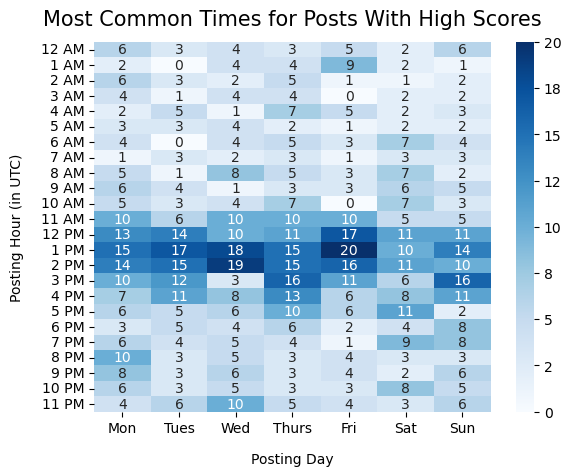

In [14]:
from matplotlib.ticker import FixedLocator
# Creates a heatmap of the posting data
sns.heatmap(df.pivot_table(index='posting_hour', 
                           columns='day_of_the_week',
                           values='upvote_strength', 
                           aggfunc='sum'), 
                           cmap='Blues', 
                           annot=True, 
                           cbar_kws={'format': '%.0f'})

plt.xlabel('Posting Day', labelpad=12)
plt.ylabel('Posting Hour (in UTC)', labelpad=12)

# Displays the day of the week on the X axis. The numeric value is purely for centering the label display
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], 
           ['Mon', 'Tues', 'Wed', 
            'Thurs','Fri', 'Sat', 'Sun'],)

# Displays the posting hour on the Y axis. The numeric value is purely for centering the label display
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 
            13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5, 22.5, 23.5],
            ['12 AM', '1 AM', '2 AM', '3 AM', '4 AM', 
            '5 AM', '6 AM', '7 AM', '8 AM', '9 AM', 
            '10 AM', '11 AM', '12 PM', '1 PM', '2 PM', 
            '3 PM', '4 PM', '5 PM', '6 PM', '7 PM', '8 PM', 
            '9 PM', '10 PM', '11 PM'],
            rotation=0)

with capture_output() as captured:             
    plt.title('Most Common Times for Posts With High Scores', pad=12, fontsize=15)

<p style="max-width: 1000px; font-size: 15.5px">This heatmap shows the most frequent days and times with high score posts. From this diagram, there is an obvious trend that posts with high scores cluster around a certain time of day. The 11AM-5PM range in UTC generally is where the largest amounts of high scoring posts reside. 1PM and 2PM UTC on Wednesday and Friday are two highest frequecies of high scoring posts. This kind of pattern was picked up on by the AI which lead to its ability to make the difficult prediction of determing if a time and date was more likely to produce a high score.</p>

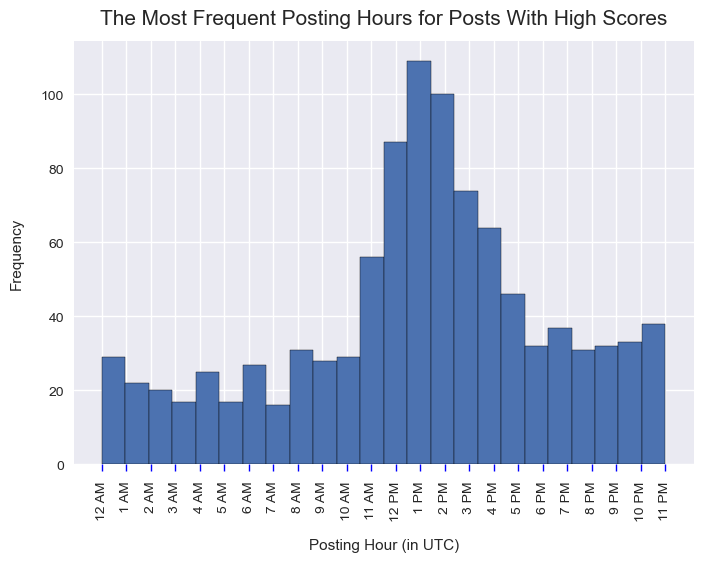

In [15]:
# Create a histogram of the high score posting data
highscore_posts = df.loc[df['upvote_strength'] == 1, 'posting_hour']
create_histogram(highscore_posts, 'The Most Frequent Posting Hours for Posts With High Scores')    

<p style="max-width: 1000px; font-size: 15.5px">The above histogram offers a different perspective of the data, showing the most frequent posting hour of high score posts regardless of what day it is. It becomes much easier to see the trends and spikes around 1PM and 2PM UTC with this visual representation.  </p>

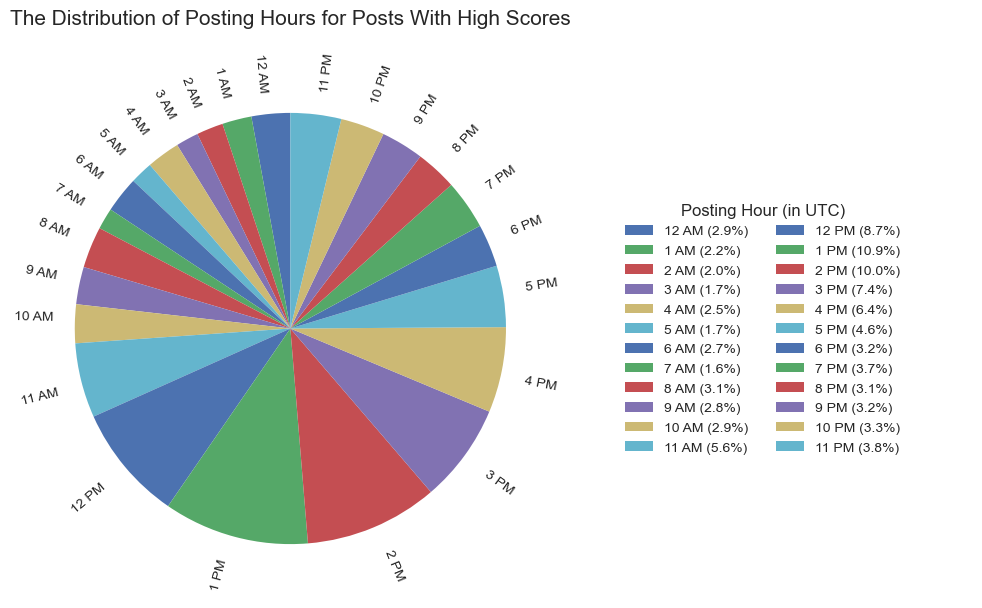

In [16]:
# Create a pie chart of the high score posting data
highscore_posts = df.loc[df['upvote_strength'] == 1, 'posting_hour']
create_pie(highscore_posts, 'The Distribution of Posting Hours for Posts With High Scores')

<p style="max-width: 1000px; font-size: 15.5px">The final high score post diagram gives more insight into how the posting hours were distributed. The pie chart shows each hour and how impactful that hour was in UTC relative to the other hours. There is much larger emphasis on times past 11AM and before 6PM. The distribution becomes more even at those times offering smaller benefits between them but overall, it is a good time range that could potentially provide successful engagements. More so, these are just predictive patterns that show the bias between certain times and high scoring posts. Next, low scoring posts are going to be explored.</p>

## A Closer Look at Low Scoring Posts Through Visualization

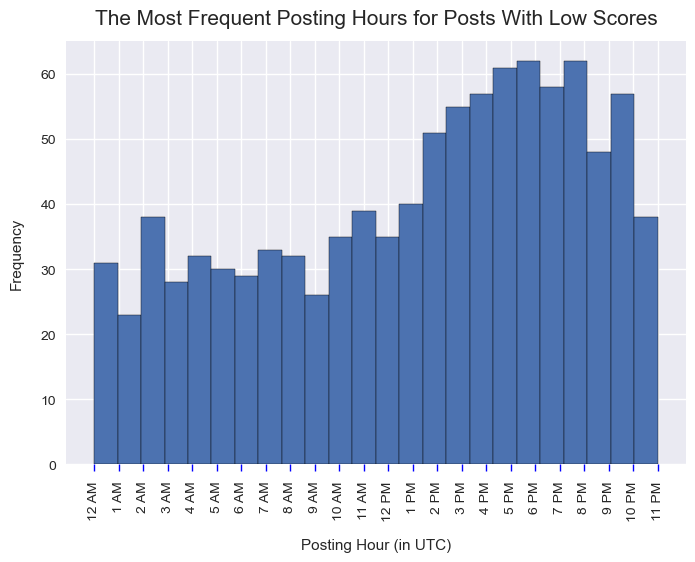

In [17]:
# Create a histogram of the low score posting data
lowscore_posts = df.loc[df['upvote_strength'] == 0, 'posting_hour']
create_histogram(lowscore_posts, 'The Most Frequent Posting Hours for Posts With Low Scores')    

<p style="max-width: 1000px; font-size: 15.5px;">Immediately, the shape of the histogram looks much different than the high score post histogram. Notably, as a whole, the overall frequency of posts have a much more even distribution with no value reaching below 20 in frequency. There is still a more prominent pattern emerging past the 2PM UTC region and continuing to 10PM. This does correlate with the high score post histogram which has a low frequency of posts on those later UTC times.</p>

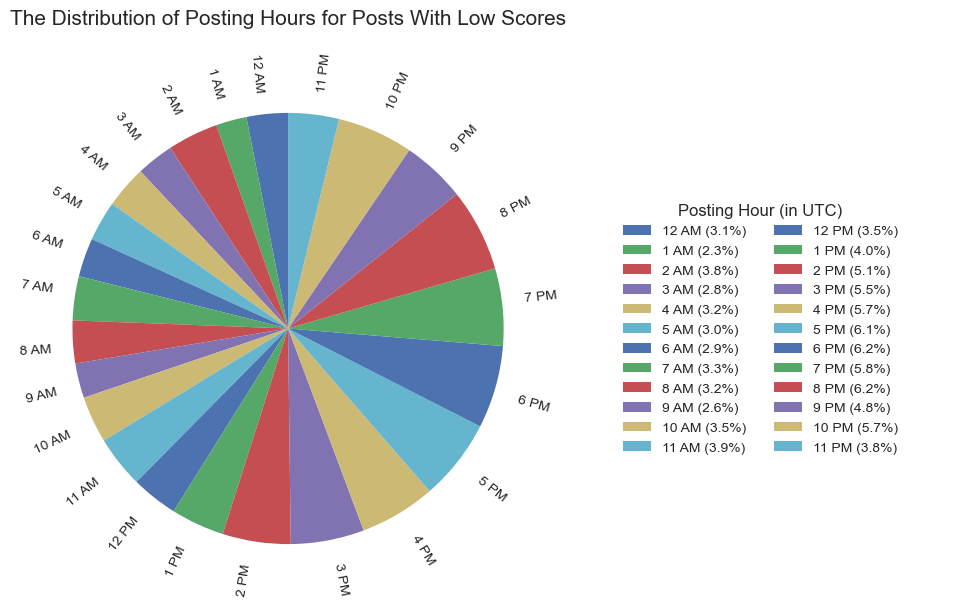

In [18]:
# Create a pie chart of the low score posting data
lowscore_posts = df.loc[df['upvote_strength'] == 0, 'posting_hour']
create_pie(lowscore_posts, 'The Distribution of Posting Hours for Posts With Low Scores')   

<p style="max-width: 1000px; font-size: 15.5px">The more uniform nature of the low scoring posts is exemplified in the above pie chart. There is a noteworthy increase of low score post distribution around the 3PM-10PM UTC area. However, the hours with the largest weight, 6PM and 8PM, only make up for 6.2% of the distribution. Compared to the high score post pie chart, hours like 1PM comprised of 10.9% of the posts which is a much larger difference. Ultimately, based upon the tests, this has manifested in the AI model being slightly better at predicting times for high scoring posts opposed to low scoring posts.</p>

## So How Accurate Is It?

In [19]:
# Predicting the Test set results
predictions = clf.predict(X_test)

In [20]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, predictions)

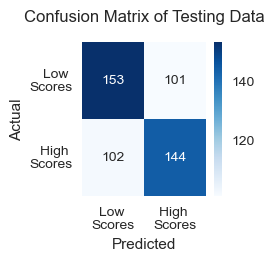

In [21]:
# Displays a visual for the confusion matrix
xtick_labels = ['Low \nScores', 'High \nScores']
ytick_labels = ['Low \nScores', 'High \nScores']
plt.figure(figsize=(2,2))
heatmap = sns.heatmap(cm,
           annot=True,
           xticklabels=xtick_labels, 
           yticklabels=ytick_labels,             
           fmt='d',
           cmap = "Blues");
plt.ylabel('Actual');
plt.xlabel('Predicted');

heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=0)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
with capture_output() as captured:  
    heatmap.set_title('Confusion Matrix of Testing Data', pad=15)

In [22]:
# Formats and displays the accuracy
accuracy = accuracy_score(y_test, predictions)
accuracy_text = f'<div style="font-size: 18px; color: black; padding-left: 10px">Accuracy:{accuracy: .1%}</div>'    
display(HTML(accuracy_text))

<p style="max-width: 1000px;  font-size: 15.5px">The model is able predict whether a date and time will produce either a low scoring condition or a high scoring condition with an accuracy of 59.4% This is about 10% higher than a random guess, but that difference is very important for engagement. There are several factors that go into what makes a post viable from title, content, subreddit type, whether the post is a question, server conditions, subject matter, and more. The fact that the model can boost a posts potential by 10% with purely posting time alone is a worthwhile advantage. On reddit, a post is several times more likely to succeed once you have as little as three upvotes. This kind of 10% advantage can offer those needed upvotes and allow you to push past other competition. In addition to that, despite the guesses not all being accurate, are all distributed more closely to times that tend to perform better, instead of randomly distributed. That means that despite the model not getting it right due to the extreme difficulty of predicting a post's success off time alone, it is more likely to provide a great posting hour that will maximize exposure no matter when the AI is asked.</p>

# Summary

<p style="max-width: 1000px; font-size: 15.5px">This website offers a competitive advantage for posting to social media using nothing but the date and time. This is something that is very easy to control and can provide a noteworthy benefit to propel your user engagement beyond a random guess. Using this tool easily answers the question of "what time should I post?" and offers the best posting time based upon machine learning and social media expertise. The model will be constantly improved with more features and platforms added to enhance the experience and ensure more accuracy in the future.</p>